In [ ]:
#Install all the required library
pip install shap
pip install lime
pip install interpret

In [23]:
#import all the neccesary libraries.
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.inspection import plot_partial_dependence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import shap
import lime
from lime import lime_tabular
from interpret.blackbox import LimeTabular
from interpret import show
% matplotlib inline

In [24]:
#import the breast cancer dataset 
dat = datasets.load_breast_cancer()

In [25]:
print("The sklearn breast cancer dataset keys:")
print(dat.keys()) # dict_keys(['target_names', 'target', 'feature_names', 'data', 'DESCR'])
print("---")

# Note that we need to reverse the original '0' and '1' mapping in order to end up with this mapping:
# Benign = 0 (negative class)
# Malignant = 1 (positive class)

li_classes = [dat.target_names[1], dat.target_names[0]]
li_target = [1 if x==0 else 0 for x in list(dat.target)]
li_ftrs = list(dat.feature_names)

print("There are 2 target classes:")
print("li_classes", li_classes)
print("---")
print("Target class distribution from a total of %d target values:" % len(li_target))
print(pd.Series(li_target).value_counts())
print("---")

df = pd.DataFrame(dat.data[:,:], columns=li_ftrs)
print("Describe dataframe, first 6 columns:")
print(df.iloc[:,:6].describe().to_string())

The sklearn breast cancer dataset keys:
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
---
There are 2 target classes:
li_classes ['benign', 'malignant']
---
Target class distribution from a total of 569 target values:
0    357
1    212
dtype: int64
---
Describe dataframe, first 6 columns:
       mean radius  mean texture  mean perimeter    mean area  mean smoothness  mean compactness
count   569.000000    569.000000      569.000000   569.000000       569.000000        569.000000
mean     14.127292     19.289649       91.969033   654.889104         0.096360          0.104341
std       3.524049      4.301036       24.298981   351.914129         0.014064          0.052813
min       6.981000      9.710000       43.790000   143.500000         0.052630          0.019380
25%      11.700000     16.170000       75.170000   420.300000         0.086370          0.064920
50%      13.370000     18.840000       86.240000   551.100000     

In [26]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [27]:
X=df.iloc[:9]
y = pd.Series(li_target)

In [28]:
X.drop(['radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],axis=1,inplace=True)

In [29]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [42]:
#Split the dataset to avoid overfitting
X_train,X_test,y_train,y_test=train_test_split(df,
                                              y,test_size=0.3,random_state=100)

In [43]:
#Create a Decision Tree Classifier Instance and embed it with the RFECV Method
#And fit the model to the training data
rfc = DecisionTreeClassifier()
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X_train,y_train)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), scoring='accuracy')

In [44]:
#Create a dataset with selected features
print(np.where(rfecv.support_ == False)[0])
X_train.drop(X_train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[ 0  2  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 22 24 25 26 28 29]


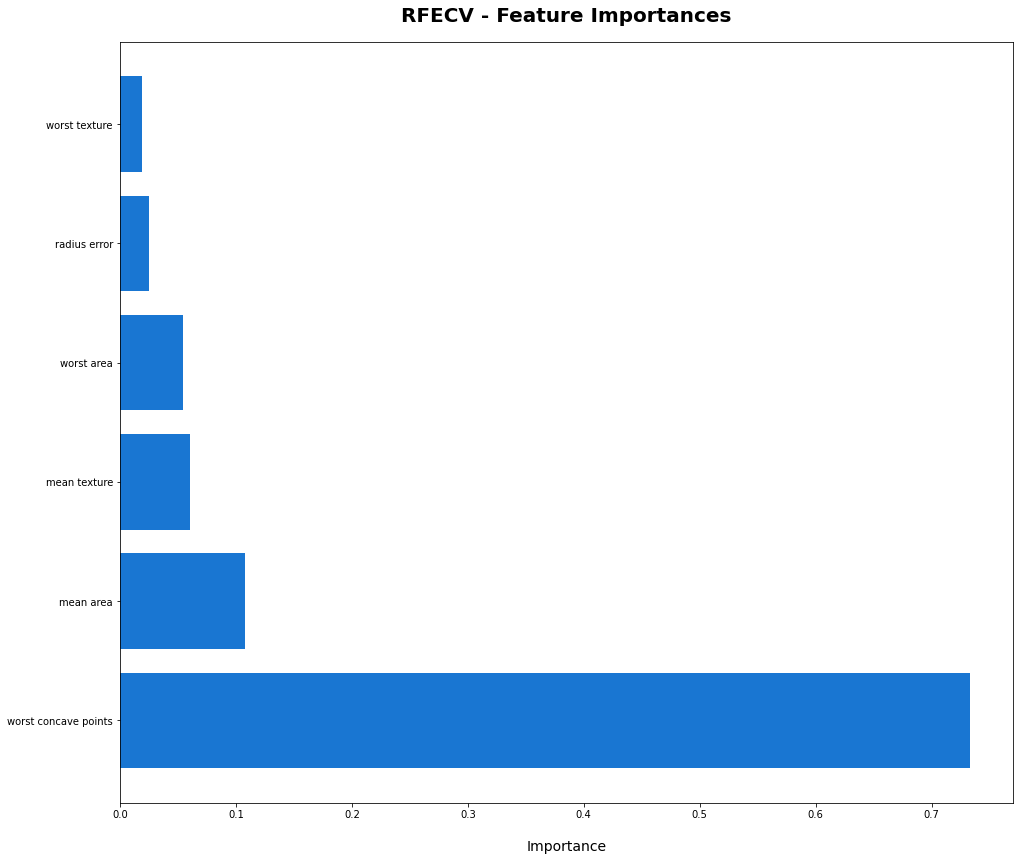

In [45]:
#plotting the feature Importance graph
dset = pd.DataFrame()
dset['attr'] = X_train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [46]:
X_train.head()

,mean texture,mean area,radius error,worst texture,worst area,worst concave points
18,22.15,1260.0,0.7582,30.88,2398.0,0.23880
213,25.56,948.0,0.5296,28.07,1021.0,0.10990
532,16.33,575.5,0.2047,20.20,773.4,0.08704
191,21.41,507.4,0.7311,23.50,579.5,0.04773
235,21.25,603.4,0.2589,30.28,715.5,0.07963


In [47]:
#Drop the reduntant features in test data
X_test.drop(X_test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X_test.head()

,mean texture,mean area,radius error,worst texture,worst area,worst concave points
400,21.02,994.0,0.4030,27.78,1304.0,0.19640
225,13.47,641.2,0.5220,16.90,873.2,0.10870
321,19.66,1274.0,0.5925,23.03,1657.0,0.14250
173,14.71,372.7,0.2073,16.82,396.5,0.04306
506,20.04,453.1,0.1811,24.17,515.3,0.08088


In [49]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
 
# metrics are used to find accuracy or error

print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.9590643274853801


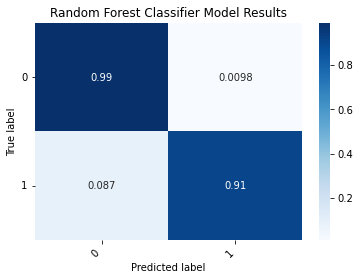

In [50]:
#plot a confusion matrix for true positives and true negatives
conmat = confusion_matrix(y_test, y_pred)
val = np.mat(conmat)
classnames = list(set(y_train))
df_cm = pd.DataFrame(
val, index=classnames, columns=classnames,
)
df_cm = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]
plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap='Blues')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Random Forest Classifier Model Results')
plt.show()

# Partial Dependence Plots (PDP) 

<Figure size 432x288 with 0 Axes>

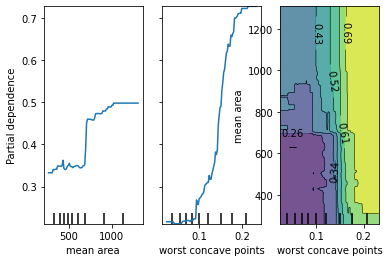

In [54]:
#plot the partial dependence plot
features = [1, 5, (5, 1)]
plt.figure()
plot_partial_dependence(clf, X_train, features)
plt.show()

In [53]:
X_train.head()

,mean texture,mean area,radius error,worst texture,worst area,worst concave points
18,22.15,1260.0,0.7582,30.88,2398.0,0.23880
213,25.56,948.0,0.5296,28.07,1021.0,0.10990
532,16.33,575.5,0.2047,20.20,773.4,0.08704
191,21.41,507.4,0.7311,23.50,579.5,0.04773
235,21.25,603.4,0.2589,30.28,715.5,0.07963


# **Random Forest Model Feature Importance**

[0.04505976 0.13511529 0.09651764 0.05078517 0.29435283 0.3781693 ]


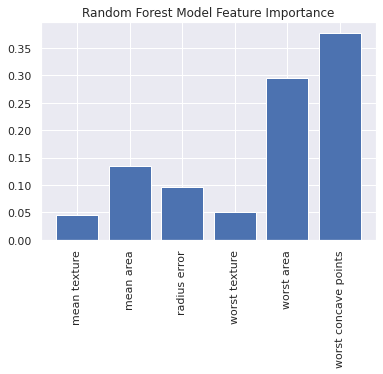

In [56]:
#plot the feature importance using feature_importance_
features = ['mean texture','mean area',	'radius error',	'worst texture',	'worst area'	,'worst concave points']
print(clf.feature_importances_)
feature_df = pd.DataFrame({'Importance':clf.feature_importances_, 'Features': features })
sns.set()
plt.bar(feature_df['Features'], feature_df['Importance'])
plt.xticks(rotation=90)
plt.title('Random Forest Model Feature Importance')
plt.show()

# **Individual Condition Expectations plots (ICE)**

<Figure size 432x288 with 0 Axes>

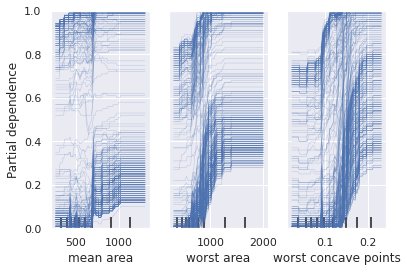

In [59]:
#Plot theIndividual Condition Expectations Plots(ICE) with plot_partial_dependence function  with the
# kiund attribute as 'individual'
features = [1,4, 5]
plt.figure()
plot_partial_dependence(clf, X_train, features,kind='individual')
plt.show()

# **LIME and SHAP for Neural Network Model**

In [61]:
#For demonstrating LIME and SHAP Methods
#We are gonna create a sequential Neural Network with 3 three layers
model = Sequential()

In [63]:
features = ['mean texture','mean area',	'radius error',	'worst texture',	'worst area'	,'worst concave points']

In [65]:
model.add(Dense(8, input_shape = (len(features),)))
model.add(Dense(8, activation='relu'))

In [66]:
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
model.fit(X_train, y_train, epochs = 40)

Epoch 1/40
13/13 [==============================] - 0s 2ms/step - loss: 0.4314 - accuracy: 0.8593
Epoch 2/40
13/13 [==============================] - 0s 2ms/step - loss: 0.3901 - accuracy: 0.8794
Epoch 3/40
13/13 [==============================] - 0s 2ms/step - loss: 0.4298 - accuracy: 0.8568
Epoch 4/40
13/13 [==============================] - 0s 3ms/step - loss: 0.4592 - accuracy: 0.8392
Epoch 5/40
13/13 [==============================] - 0s 2ms/step - loss: 0.5624 - accuracy: 0.8191
Epoch 6/40
13/13 [==============================] - 0s 2ms/step - loss: 0.5124 - accuracy: 0.8417
Epoch 7/40
13/13 [==============================] - 0s 2ms/step - loss: 0.4702 - accuracy: 0.8643
Epoch 8/40
13/13 [==============================] - 0s 2ms/step - loss: 0.4198 - accuracy: 0.8593
Epoch 9/40
13/13 [==============================] - 0s 2ms/step - loss: 0.5111 - accuracy: 0.8518
Epoch 10/40
13/13 [==============================] - 0s 2ms/step - loss: 0.4071 - accuracy: 0.8643
Epoch 11/40
13/13 [

In [70]:
y_pred = [round(float(x)) for x in model.predict(X_test)]

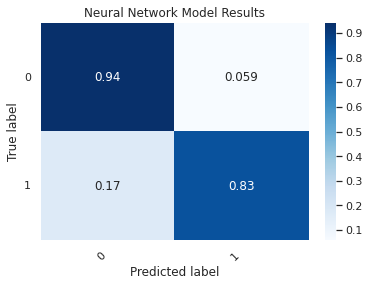

In [74]:
conmat = confusion_matrix(y_test, y_pred)
val = np.mat(conmat)
classnames = list(set(y_train))
df_cm_nn = pd.DataFrame(
val, index=classnames, columns=classnames,
)
df_cm_nn = df_cm_nn.astype('float') / df_cm_nn.sum(axis=1)[:, np.newaxis]
plt.figure()
heatmap = sns.heatmap(df_cm_nn, annot=True, cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Neural Network Model Results')
plt.show()

Exact explainer: 172it [00:15,  3.90it/s]


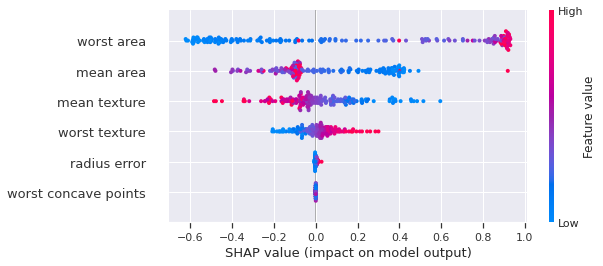

In [77]:
# We will be using Explainer method of shap Library to get shap values
f = lambda x: model.predict(x)
med = X_train.median().values.reshape((1,X_train.shape[1]))
explainer = shap.Explainer(f, med)
shap_values = explainer(X_test.iloc[0:1000,:])
shap.plots.beeswarm(shap_values)

# LIME METHOD

In [80]:
#Create a Instance of Lime tabular Method and print the probability table
explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train),feature_names=X_train.columns,class_names=['Yes', 'No'],
mode='classification')
exp = explainer.explain_instance(data_row=X_test.iloc[1], predict_fn=model.predict, labels=(0,))
exp.show_in_notebook(show_table=True)

In [84]:
#Create a instance of LimeTabular of Interpret Library and explain the predictions of last 20 samples of test class
lime=LimeTabular(predict_fn=clf.predict_proba,data=X_train,random_state=1)

lime_local=lime.explain_local(X_test[-20:],y_test[-20:],name='LIME')

show(lime_local)